In [97]:
#import mmh3
from io import BytesIO
import copy

In [2]:
# Hash function to generate random value between 0 to N*P-1
def gcs_hash(w, N,P):
    h = sha256(w).hexdigest()
    h = int(h[23:32],16) # make sure h[x:y] is more than N*P
    return h % (N*P)

In [3]:
def find_insertions_deletions(list1, list2):
    matcher = SequenceMatcher(None, list1, list2)
    opcodes = matcher.get_opcodes()

    insertions = 0
    deletions = 0

    for tag, i1, i2, j1, j2 in opcodes:
        if tag == 'insert':
            insertions += i2 - i1
        elif tag == 'delete':
            deletions += j2 - j1

    return insertions, deletions


In [4]:
def write_list_into_file(integer_list,output_file_path):
    with open(output_file_path, 'w') as file:
        for number in integer_list:
            file.write(f"{number}\n")

In [5]:
## Lets first try on 64000

In [6]:
import random
random.seed(13)
P = 128

In [7]:
N = 64000
numbers = random.sample(range(10000000), N)

In [8]:
len(set(numbers))

64000

In [9]:
import seaborn as sns

<Axes: ylabel='Count'>

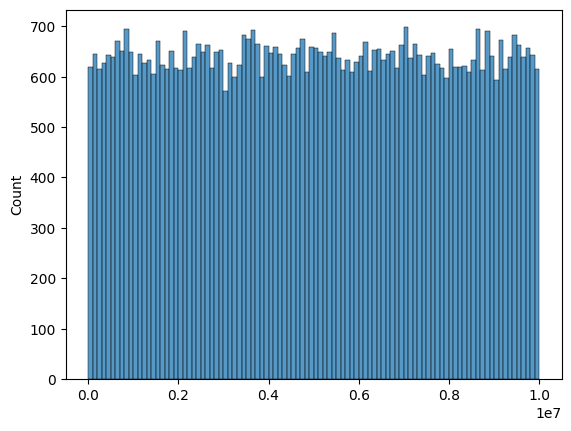

In [10]:
sns.histplot(numbers,bins=100)

In [11]:
import sys
import math
from hashlib import sha256
import struct
from array import array
import codecs
import numpy as np

In [12]:
hash_values = [0] + [gcs_hash(str(v).encode('utf-8'), N,P) for v in numbers]

In [13]:
len(hash_values)

64001

In [14]:
hash_values[:10]

[0,
 3986826,
 710624,
 8148385,
 4701749,
 6353139,
 7098816,
 4706380,
 2269995,
 7776126]

In [15]:
hash_values = sorted(hash_values)
deltas = np.array([hash_values[i]-hash_values[i-1] for i in range(1,len(hash_values))])

In [16]:
deltas[:10]

array([  6,  94, 173,  50,  18, 118,  57,   4, 362, 179])

Text(1336, 6718.95, 'Max 1336')

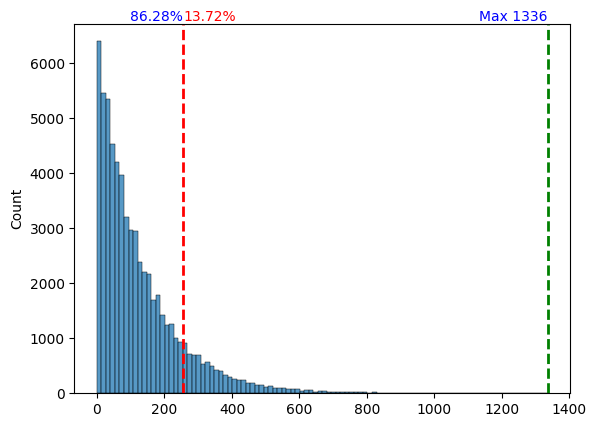

In [17]:
ax = sns.histplot(deltas,bins=100)
ax.axvline(255, color='red', linestyle='dashed', linewidth=2)
percentage_before = np.sum(deltas < 255)/N * 100
percentage_after = np.sum(deltas >= 255)/N * 100

ax.text(255, ax.get_ylim()[1], f"{percentage_before:.2f}%", color='blue', verticalalignment='bottom', horizontalalignment='right')
ax.text(255, ax.get_ylim()[1], f"{percentage_after:.2f}%", color='red', verticalalignment='bottom', horizontalalignment='left')

ax.axvline(np.max(deltas), color='green', linestyle='dashed', linewidth=2, label='Max Value')

ax.text(np.max(deltas), ax.get_ylim()[1], f"Max {np.max(deltas):}", color='blue', verticalalignment='bottom', horizontalalignment='right')


In [18]:
## Now lets try on 640000

In [19]:
N = 640000
numbers = random.sample(range(10000000), N)

<Axes: ylabel='Count'>

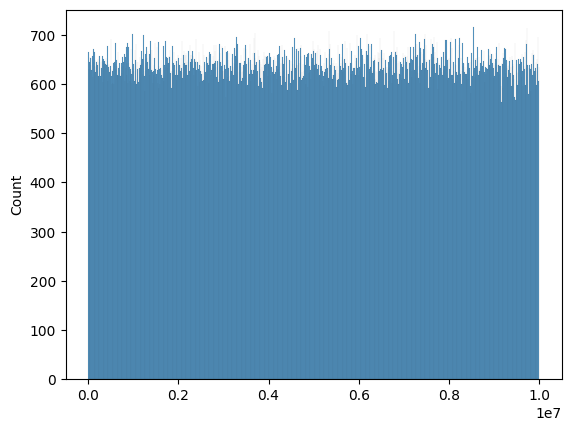

In [20]:
sns.histplot(numbers,bins=1000)

In [21]:
hash_values = [0] + [gcs_hash(str(v).encode('utf-8'), N,P) for v in numbers]
hash_values = sorted(hash_values)
deltas = np.array([hash_values[i]-hash_values[i-1] for i in range(1,len(hash_values))])

In [22]:
max(deltas)

1554

In [23]:
len(deltas)

640000

Text(1554, 76885.2, 'Max 1554')

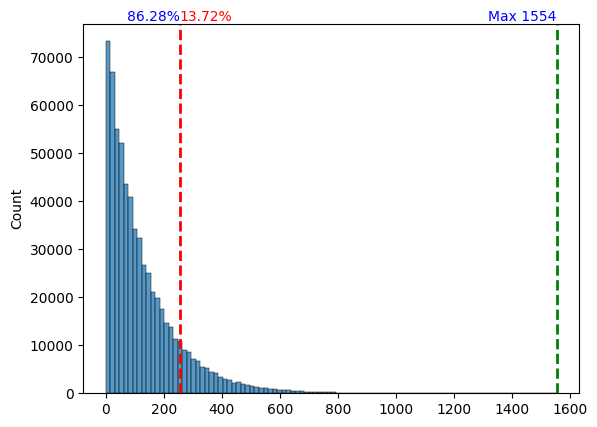

In [24]:
ax = sns.histplot(deltas,bins=100)
ax.axvline(255, color='red', linestyle='dashed', linewidth=2)
percentage_before = np.sum(deltas < 255)/N * 100
percentage_after = np.sum(deltas >= 255)/N * 100

ax.text(255, ax.get_ylim()[1], f"{percentage_before:.2f}%", color='blue', verticalalignment='bottom', horizontalalignment='right')
ax.text(255, ax.get_ylim()[1], f"{percentage_after:.2f}%", color='red', verticalalignment='bottom', horizontalalignment='left')

ax.axvline(np.max(deltas), color='green', linestyle='dashed', linewidth=2, label='Max Value')

ax.text(np.max(deltas), ax.get_ylim()[1], f"Max {np.max(deltas):}", color='blue', verticalalignment='bottom', horizontalalignment='right')


In [27]:
adjusted_deltas = [0]
non_dummy_count = 0
dummy_count = 0
lookup_22_block_indices = []
running_value = 0
counter = 0
lookup_22_block_indices.append((0,0))
index = 0
for d in deltas:
    if d==255:
        non_dummy_count+=1
    while d>255:
        dummy_count+=1
        d = d - 255
        adjusted_deltas.append(255)
        counter+=1
        running_value+=255
        if ((running_value >> 22 ) > index):
            index = index + 1
            lookup_22_block_indices.append((counter,running_value))
    adjusted_deltas.append(d)
    counter+=1
    running_value+=d
    
    if ((running_value >> 22 ) > index):
        index = index + 1
        lookup_22_block_indices.append((counter,running_value))
    

In [28]:
lookup_22_block_indices

[(0, 0),
 (38012, 4194382),
 (75954, 8388612),
 (113899, 12583143),
 (151535, 16777382),
 (189440, 20971661),
 (227308, 25165846),
 (265471, 29360203),
 (303281, 33554509),
 (341249, 37748922),
 (379122, 41943188),
 (417161, 46137408),
 (454838, 50331666),
 (492895, 54526021),
 (530816, 58720310),
 (568732, 62914793),
 (606535, 67108878),
 (644640, 71303377),
 (682655, 75497481),
 (720526, 79691927)]

In [29]:
non_dummy_count,dummy_count

(702, 100791)

In [30]:
len(adjusted_deltas),max(adjusted_deltas),min(adjusted_deltas)

(740792, 255, 0)

In [31]:
adjusted_deltas = np.array(adjusted_deltas)

In [32]:
np.sum(adjusted_deltas>255),(len(adjusted_deltas)-N)/N*100,len(np.nonzero(adjusted_deltas == 255)[0]),len(np.nonzero(adjusted_deltas == 255)[0])/N*100

(0, 15.748750000000001, 101615, 15.87734375)

In [33]:
#Total bits = 
len(adjusted_deltas)*8

5926336

In [34]:
# bits per record = 
len(adjusted_deltas)*8/N

9.2599

In [35]:
def write_packed(file_path, array):
    with open(file_path, 'wb') as file:
        for value in array:
            packed_data = struct.pack('<B', value)
            file.write(packed_data)
def read_packed(file_path):
    read_array = []
    with open(file_path, 'rb') as file:
        while True:
            byte = file.read(1)
            if not byte:
                break
            value = struct.unpack('<B', byte)[0]
            read_array.append(value)
    return read_array

In [36]:
write_packed('gcs.bin',adjusted_deltas)

In [37]:
read_deltas = read_packed('gcs.bin')

In [38]:
read_deltas[:10],adjusted_deltas[:10],len(read_deltas),len(adjusted_deltas)

([0, 86, 255, 219, 255, 77, 195, 255, 27, 240],
 array([  0,  86, 255, 219, 255,  77, 195, 255,  27, 240]),
 740792,
 740792)

In [39]:
# Now lets query

In [40]:
Q = 100000
query_numbers = random.sample(range(10000000), Q)
input_numbers = set(numbers)

In [41]:
non_matching_input = [x for x in query_numbers if x not in input_numbers]

In [42]:
len(non_matching_input)

93640

In [43]:
matching_input = [x for x in query_numbers if x  in input_numbers]

In [44]:
len(matching_input)

6360

In [45]:
# lets reconstuct the hash values fully

In [46]:
reconstruct_hash_values = [0]
for i in range(1,len(read_deltas)):
    reconstruct_hash_values.append(read_deltas[i]+reconstruct_hash_values[-1])

In [47]:
reconstruct_hash_values[:10],reconstruct_hash_values[-10:]

([0, 86, 341, 560, 815, 892, 1087, 1342, 1369, 1609],
 [81918832,
  81918900,
  81918917,
  81919001,
  81919114,
  81919257,
  81919294,
  81919394,
  81919649,
  81919691])

In [48]:
hash_values[:11],hash_values[-10:]

([0, 86, 560, 892, 1087, 1369, 1609, 1664, 2127, 2194, 2198],
 [81918390,
  81918577,
  81918900,
  81918917,
  81919001,
  81919114,
  81919257,
  81919294,
  81919394,
  81919691])

In [49]:
assert set(hash_values)-set(reconstruct_hash_values)==set()

In [50]:
assert(len(set(reconstruct_hash_values).intersection(set(hash_values)))==len(np.unique(hash_values)))

In [51]:
## Assuming we can load it all in memory - use binary search

In [52]:
reconstruct_hash_values_set = set(reconstruct_hash_values)

In [53]:
import time
start = time.time()

fp_counter = 0
for q in non_matching_input:
    if gcs_hash(str(q).strip().encode('utf-8'),N,P) in reconstruct_hash_values_set:
        fp_counter+=1
end = time.time()
print(end - start)

0.18118715286254883


In [54]:
0.19/93640 # per lookup

2.0290474156343444e-06

In [55]:
fp_counter

824

In [56]:
# Fp Rate
fp_counter/Q

0.00824

In [57]:
start = time.time()

tp_counter = 0
for i in range(100): ## only to simulate more lookups
    for q in matching_input:
        lookup = gcs_hash(str(q).strip().encode('utf-8'),N,P)
        if lookup in reconstruct_hash_values_set:
            tp_counter+=1
end = time.time()
print(end - start)

1.474254846572876


In [58]:
1.423518180847168/(100*6360) # per lookup

2.2382361334074967e-06

In [59]:
assert tp_counter==len(matching_input)*100

In [60]:
## Now lets try to do it withuot loading into memory and using the indices already saved

In [61]:
q

8786757

In [62]:
lookup = gcs_hash(str(q).strip().encode('utf-8'),N,P)
lookup

27382912

In [63]:
lookup in reconstruct_hash_values_set

True

In [64]:
lookup >> 22

6

In [65]:
# so we start at 
lookup_22_block_indices[(lookup >> 22)-1][1],lookup_22_block_indices[(lookup >> 22)-1][0]

(20971661, 189440)

In [66]:
q in numbers

True

In [67]:
start_at = lookup_22_block_indices[(lookup >> 22)][0]
v = lookup_22_block_indices[(lookup >> 22)][1]
delta_needed = lookup-v
d=0;i=1
while(d<delta_needed):
    d+=read_deltas[start_at+i]
    i+=1
if d==delta_needed:
    print('Found')

Found


In [68]:
d

2217066

In [69]:
delta_needed

2217066

In [70]:
lookup_22_block_indices

[(0, 0),
 (38012, 4194382),
 (75954, 8388612),
 (113899, 12583143),
 (151535, 16777382),
 (189440, 20971661),
 (227308, 25165846),
 (265471, 29360203),
 (303281, 33554509),
 (341249, 37748922),
 (379122, 41943188),
 (417161, 46137408),
 (454838, 50331666),
 (492895, 54526021),
 (530816, 58720310),
 (568732, 62914793),
 (606535, 67108878),
 (644640, 71303377),
 (682655, 75497481),
 (720526, 79691927)]

In [75]:
# Try changing this to reading the delta directly from file
# using file offset
def running_lookup(q):
    lookup = gcs_hash(str(q).strip().encode('utf-8'),N,P)
    index = lookup >> 22
    start_at = lookup_22_block_indices[index][0]
    v = lookup_22_block_indices[index][1]
    delta_needed = lookup-v
    if delta_needed < 0:
        print(q,lookup,start_at,v)
    d=0;i=1
    while(d<delta_needed):
        d+=read_deltas[start_at+i]
        i+=1
    if d==delta_needed:
        return 1
    else:
        return 0

In [76]:
start = time.time()

tp_counter = 0
for q in matching_input:
    if running_lookup(q):
        tp_counter+=1
end = time.time()
print(end - start)

18.579031705856323


In [77]:
tp_counter

6360

In [78]:
assert tp_counter==len(matching_input)

In [79]:
18.579031705856323/6360

0.0029212314002918746

In [80]:
# Delta test
# Add ~20000 new hashes
# Remove 20000 old hashes

In [81]:
new_numbers =  set(random.sample(range(10000000), 22300))
new_numbers.difference_update(set(numbers))

In [82]:
len(set(new_numbers).intersection(set(numbers)))

0

In [83]:
len(new_numbers)

20853

In [84]:
new_numbers = list(new_numbers)
new_numbers = new_numbers[len(new_numbers)-20000:]

In [85]:
len(new_numbers)

20000

In [86]:
delete_numbers = random.sample(numbers,20000)

In [87]:
len(delete_numbers)

20000

In [88]:
new_numbers = set(new_numbers)

In [89]:
new_release_numbers = set(numbers)
print(len(new_release_numbers))
new_release_numbers.difference_update(set(delete_numbers))
print(len(new_release_numbers))
new_release_numbers.update(new_numbers)
print(len(new_release_numbers))
new_release_numbers = list(new_release_numbers)

640000
620000
640000


In [90]:
new_hash_values = [0] + [gcs_hash(str(v).encode('utf-8'), N,P) for v in new_release_numbers]
new_hash_values = sorted(new_hash_values)
new_deltas = np.array([new_hash_values[i]-new_hash_values[i-1] for i in range(1,len(new_hash_values))])
new_adjusted_deltas = [0]
for d in new_deltas:
    while d>255:
        d = d - 255
        new_adjusted_deltas.append(255)
        
    new_adjusted_deltas.append(d)
write_packed('gcs2.bin',new_adjusted_deltas)

In [91]:
new_adjusted_deltas[:10],len(new_adjusted_deltas)

([0, 86, 255, 219, 189, 143, 195, 255, 27, 240], 740680)

In [92]:
adjusted_deltas[:10],len(adjusted_deltas)

(array([  0,  86, 255, 219, 255,  77, 195, 255,  27, 240]), 740792)

In [93]:
write_list_into_file(adjusted_deltas,'adjusted_deltas')
write_list_into_file(new_adjusted_deltas,'new_adjusted_deltas')

In [111]:
!ls -lrt gcs.bin

-rw-r--r--  1 db733831  staff  740792 Oct  7 20:34 gcs.bin


In [112]:
!ls -lrt gcs2.bin

-rw-r--r--  1 db733831  staff  740680 Oct  7 20:36 gcs2.bin


In [94]:
!xdelta3 -e -s gcs.bin gcs2.bin gcs.patch 

In [95]:
!ls -lrt gcs.patch 

-rw-r--r--  1 db733831  staff  207199 Oct  7 20:38 gcs.patch


In [99]:
# Traditional BF

In [100]:
import math
N=26
P=64

# Number of bits needed to incode N items with approx 1/100 flase positive rate
m=round(-N*np.log(1/P)/(np.log(2)*np.log(2)))
print('m=',m)

# Number of hash functions needed 
k=round((m/N)*np.log(2))
print('k=',k)

# Calculating false positive rate again with optimum k
p = math.pow((1/2),k)
print('p=',p)

# Bits per element
b=-1.44*np.log2(p)  # or k/ln(2)
print('b=',b)

m= 225
k= 6
p= 0.015625
b= 8.64


In [101]:
N=640000
P=128

# Number of bits needed to incode N items with approx 1/100 flase positive rate
m=round(-N*np.log(1/P)/(np.log(2)*np.log(2)))
print('m=',m)

# Number of hash functions needed 
k=round((m/N)*np.log(2))
print('k=',k)

# Calculating false positive rate again with optimum k
p = math.pow((1/2),k)
print('p=',p)

# Bits per element
b=-1.44*np.log2(p)  # or k/ln(2) # or m/N
print('b=',b)

m= 6463274
k= 7
p= 0.0078125
b= 10.08


In [104]:
!./gcs build hashes_v1.txt

numwords: 640000


In [105]:
! ls -lrt table.gcs

-rw-r--r--  1 db733831  staff  684368 Oct  7 20:45 table.gcs


In [106]:
! mv table.gcs table_old.gcs

In [107]:
!./gcs build hashes_v2.txt

numwords: 640000


In [108]:
! mv table.gcs table_new.gcs

In [109]:
!xdelta3 -e -s table_old.gcs table_new.gcs table.patch 

In [110]:
!ls -lrt table.patch 

-rw-r--r--  1 db733831  staff  630946 Oct  7 20:47 table.patch
